#### Lilian Nguyen
#### 04/2025
#### Project 2 Part 2
#### The purpose of this notebook is to answer 4 questions about the data I scraped from 5 different webpages using plots, charts, and explanations.
##### References:
##### How to use matplotlib and seaborn: https://www.kaggle.com/code/nileshely/accelerating-auto-market-insights
##### How to make web scraping pipeline: https://www.scraperapi.com/web-scraping/realtor/
##### How to use selenium: https://builtin.com/articles/selenium-web-scraping
##### Selenium: https://brightdata.com/blog/how-tos/using-selenium-for-web-scraping 
##### Using machine learning to make prediction: https://medium.com/@deepml1818/predicting-stock-prices-with-machine-learning-in-python-a-step-by-step-guide-c53f36ab1ccd

In [5]:
pip install --upgrade undetected-chromedriver selenium webdriver-manager pandas requests

Note: you may need to restart the kernel to use updated packages.


Page loaded: https://www.realtor.com/realestateandhomes-search/08757
Listings found: 42
ZIP search/08757 returned 42
Page loaded: https://www.realtor.com/realestateandhomes-search/07470
Listings found: 42
ZIP search/07470 returned 42
Page loaded: https://www.realtor.com/realestateandhomes-search/07043
Listings found: 33
ZIP search/07043 returned 33
Page loaded: https://www.realtor.com/realestateandhomes-search/07108
Listings found: 42
ZIP search/07108 returned 42
Page loaded: https://www.realtor.com/realestateandhomes-search/07005
Listings found: 39
ZIP search/07005 returned 39
city
None        148
NJ 08757     10
NJ 07470     10
NJ 07043     10
NJ 07108     10
NJ 07005     10
Name: count, dtype: int64

Data:
      price  beds  baths    sqft      city
0  354000.0   2.0    2.0  6098.0  NJ 08757
1  310000.0   2.0    1.0  4792.0  NJ 08757
2  410000.0   2.0    2.0  6534.0  NJ 08757
3  269900.0   2.0    2.0  5249.0  NJ 08757
4  295500.0   2.0    2.0  7405.0  NJ 08757
city
NJ 08757    10
NJ 

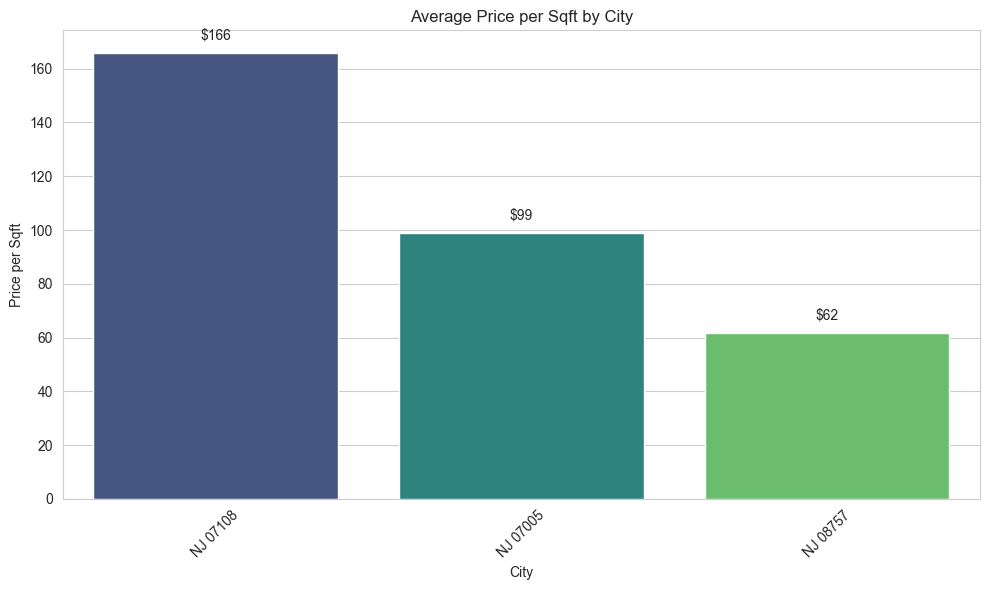

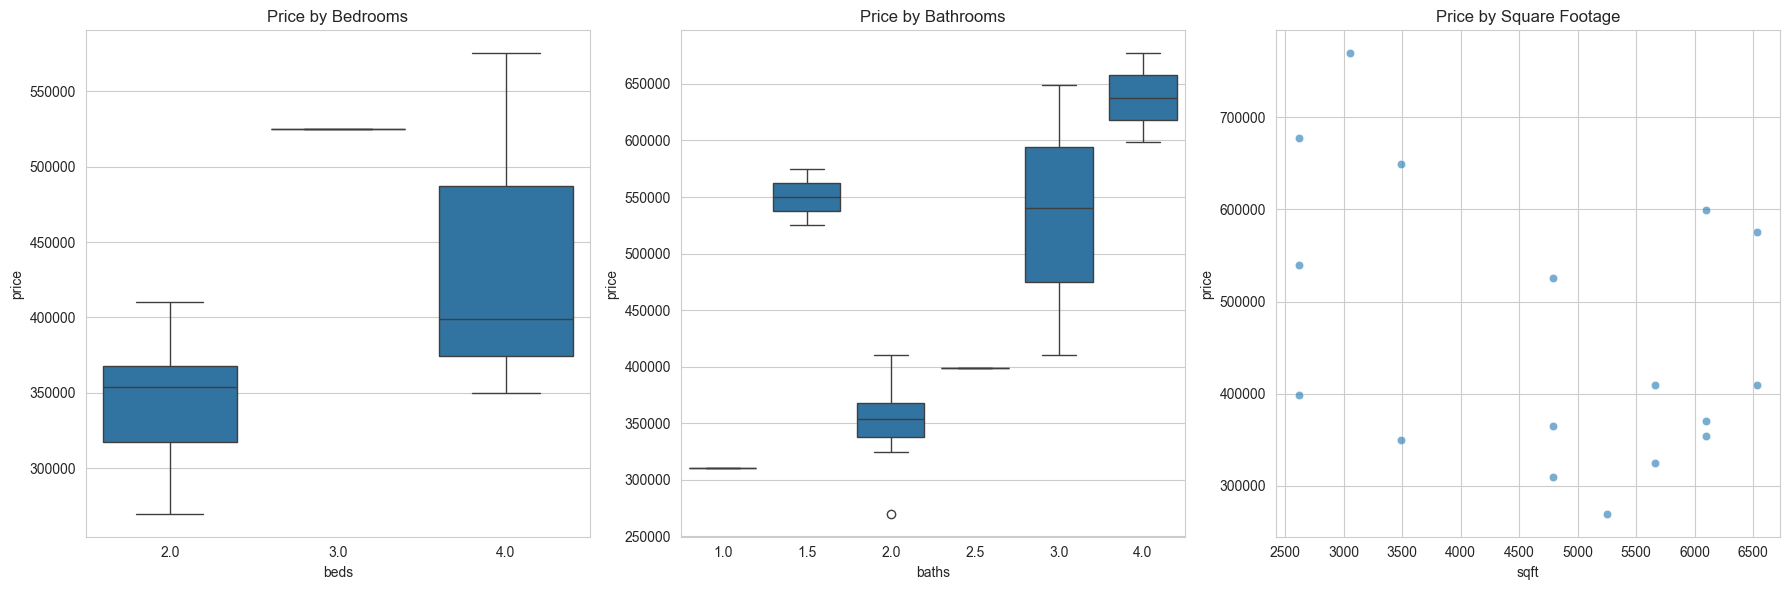

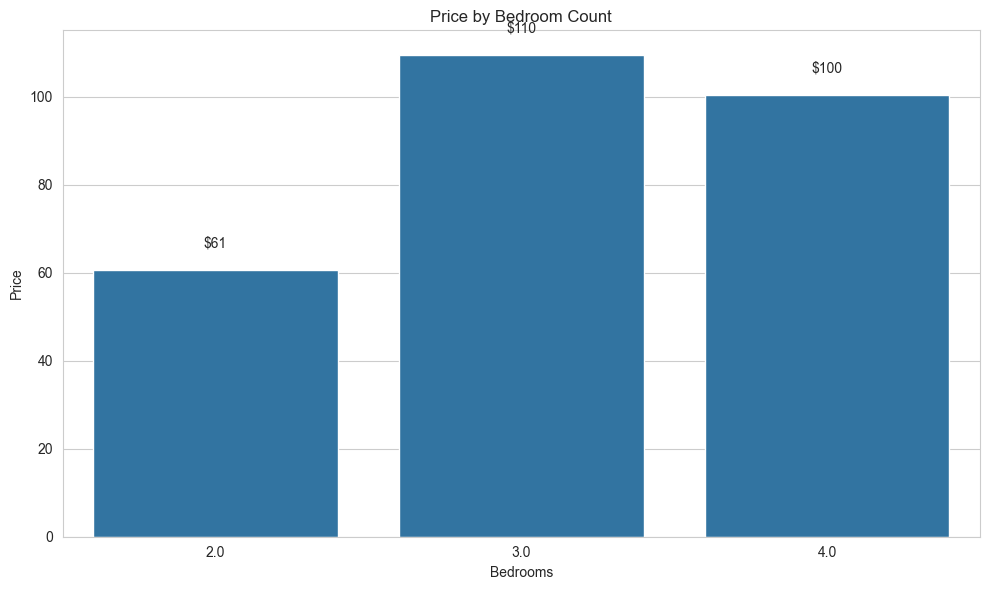

R-squared Score: 0.90
Mean Absolute Error: $30,459
Root Mean Squared Error: $34,532


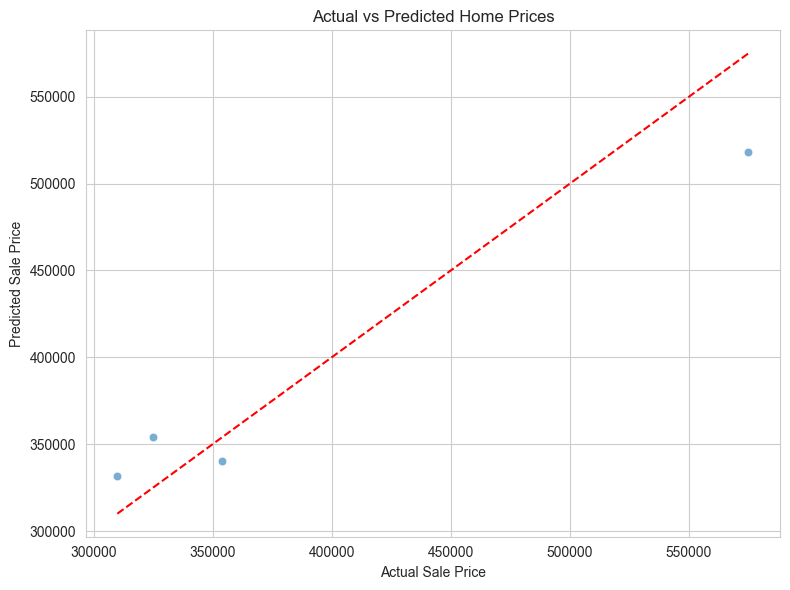

In [8]:
import time
import pandas as pd
import undetected_chromedriver as uc
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


#Setting up plot style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'Arial'

#Setting up Chrome driver for scraping
options= Options()
options.headless = False

#Formatting the driver
driver = uc.Chrome(service = Service(ChromeDriverManager().install()), options=options)
wait = WebDriverWait(driver, 20)

#Function to get the web page
def fetch_page_data(url):
    driver.get(url)
    print(f"Page loaded: {driver.current_url}")

#Checking website if it has loaded
    try:
        wait.until(EC.presence_of_all_elements_located(
            (By.CSS_SELECTOR, "div[class^='BasePropertyCard_propertyCardWrap__']")))
    except Exception as e:
        print(f"Error: {e}")
        return []
#Checking if page has listing and shows how many listings were found        
    listings = driver.find_elements(By.CSS_SELECTOR, "div[class^='BasePropertyCard_propertyCardWrap__']")
    print(f"Listings found: {len(listings)}")

#Pulling data from the website like price, address, number of bedrooms, bathrooms, and square footage
    data = []
    for listing in listings:
        try:
            price = int(listing.find_element(By.CSS_SELECTOR, "div[class^='Pricestyles__StyledPrice-rui__']").text.replace("$", "").replace(",", "").split()[0])
        except:
            price = None

        try:
            address_parts = listing.find_element(By.CLASS_NAME, "card-address").text.strip().split(", ")
            city = address_parts[1] if len(address_parts) > 1 else "Unknown"
        except:
            city = None

        try:
            beds = int(listing.find_element(By.CLASS_NAME, "PropertyBedMetastyles__StyledPropertyBedMeta-rui__a4nnof-0").find_element(By.XPATH, ".//span[@data-testid='meta-value']").text.strip())
        except:
            beds = None

        try:
            baths = float(listing.find_element(By.CLASS_NAME, "PropertyBathMetastyles__StyledPropertyBathMeta-rui__sc-67m6bo-0").find_element(By.TAG_NAME, "span").text.strip())
        except:
            baths = None

        try:
            sqft_text = listing.find_element(By.CSS_SELECTOR, "li[data-testid='property-meta-lot-size']").find_element(By.CSS_SELECTOR, "span[data-testid='screen-reader-value']").text
            sqft = int(sqft_text.strip().split()[0].replace(",", ""))
        except:
            sqft = None

        data.append({"price": price, "beds": beds, "baths": baths, "sqft": sqft, "city": city})
    return data


#Inserting the URLS needed
urls = [
    "https://www.realtor.com/realestateandhomes-search/08757",
    "https://www.realtor.com/realestateandhomes-search/07470",
    "https://www.realtor.com/realestateandhomes-search/07043",
    "https://www.realtor.com/realestateandhomes-search/07108",
    "https://www.realtor.com/realestateandhomes-search/07005"
]

#Scraping the data
fdata = []
for url in urls:
    zipcode = url.split("-")[-1]
    page_data = fetch_page_data(url)
    print(f"ZIP {zipcode} returned {len(page_data)}")
    fdata.extend(page_data)
    time.sleep(2)
    
#Chrome closes after scraping data
driver.quit()

#Creating the data frame and checking if there is data
df = pd.DataFrame(fdata)
print(df["city"].value_counts(dropna=False))
print("\nData:")
print(df.head())

df["zip"] = df["city"].str.extract(r'(\d{5})')

#Cleaning data
dfc = df.dropna(subset=["price", "beds", "baths", "sqft", "city"]).copy()
dfc["price_per_sqft"] = dfc["price"] / dfc["sqft"]
dfc = dfc[(dfc["price_per_sqft"] > 50) & (dfc["price_per_sqft"] < 2000)]


#Adding price per sqft so questions can be answered
dfc["price_per_sqft"]= dfc["price"] / dfc["sqft"]
print(df["city"].value_counts())

#Grouping city to get avg price per sqft
gcity = dfc.groupby("city")["price_per_sqft"].mean().sort_values(ascending=False).reset_index()

print("\nAvg $ per Sqft by City")
print(gcity)

#Q1: Average Price per Sqft by City
plt.figure(figsize=(10, 6))
sns.barplot(data=gcity, x="city", y="price_per_sqft", hue="city", palette="viridis", legend=False)
plt.title("Average Price per Sqft by City", fontsize= 12)
plt.xlabel("City")
plt.ylabel("Price per Sqft")
#Gives the number on top of the bar
for index, row in gcity.iterrows():
    plt.text(index, row["price_per_sqft"] +5, f"${row["price_per_sqft"]:.0f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Q2: Price vs. home features
fig, axes = plt.subplots(1, 3, figsize =(18,6))

sns.boxplot(ax=axes[0], x="beds", y="price", data=dfc[dfc["beds"] <= 5])
axes[0].set_title("Price by Bedrooms")

sns.boxplot(ax=axes[1], x="baths", y="price", data=dfc[dfc["baths"] <= 4])
axes[1].set_title("Price by Bathrooms")

sns.scatterplot(ax=axes[2], x="sqft", y="price", data=dfc, alpha=0.6)
axes[2].set_title("Price by Square Footage")

plt.tight_layout()
plt.show()

#grouping bedroom count to get median
gbedroom = dfc[dfc['beds'].between(1,5)].groupby('beds')['price_per_sqft'].median().reset_index()

#Q3: Homes with more rooms go for more?
plt.figure(figsize=(10,6))
sns.barplot(data=gbedroom, x="beds", y="price_per_sqft")
plt.title("Price by Bedroom Count", fontsize=12)
plt.xlabel("Bedrooms")
plt.ylabel("Price")
for index, row in gbedroom.iterrows():
    plt.text(index, row["price_per_sqft"] + 5, f"${row['price_per_sqft']:.0f}", ha='center')
plt.tight_layout()
plt.show()

#Q4: Predict of house prices based on bedrooms, bathrooms, and square footage
#Dropping missing values
dfp = dfc.copy()
dfp = dfp[(dfp['beds'] > 0) & (dfp['baths'] > 0) & (dfp['sqft'] > 0)]

#What are the elements and what is being measured
X = dfp[['beds','baths','sqft','city']]
Y = dfp['price']


#Creating a column transformer to make separate columns for numerical and categorical data to help optimize the prediction
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), ['city']),
    ('num', StandardScaler(), ['beds', 'baths', 'sqft'])
])
#Making a pipeline to help with processsing data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#Splits the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Training the model for prediction
pipe.fit(X_train, Y_train)

#Predicting
ypred = pipe.predict(X_test)

#Finding the mean error and root mean error, also shows r square to understand the plot better
mae = mean_absolute_error(Y_test, ypred)
rmse = np.sqrt(mean_squared_error(Y_test, ypred))
r2 = r2_score(Y_test, ypred)

print(f"R-squared Score: {r2:.2f}")
print(f"Mean Absolute Error: ${mae:,.0f}")
print(f"Root Mean Squared Error: ${rmse:,.0f}")

#Creating of prediction plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=Y_test, y=ypred, alpha = 0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Home Prices")
plt.tight_layout()
plt.show()


                  


    
